# plot behavioral data

An older version used to plot behavioral data

In [14]:
import sys
import os.path as op
    
import numpy as np
import pandas as pd
import mne
import matplotlib.pyplot as plt
import pickle

module_path = op.abspath(op.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from data_analysis.functions_preprocessing import split_raws

from data_analysis.functions_behavioral import \
    (create_event_df, remove_ghost_triggers, calculate_alpha,
     join_event_dfs, remove_outliers, events_from_event_df)

# Create path to the folder "behavioral"
behav_dir = "/net/store/nbp/projects/hyperscanning/study_project/NBP_Hyperscanning/data_analysis/behavioral_data"

subject_dir = '/net/store/nbp/projects/hyperscanning/hyperscanning-2.0/mne_data/sourcedata/'

"""
pair = 202
participant = 0

# 1.2 define the subjects id and its path
subj_id = "sub-{0}_p-{1}".format(pair, participant)
subs_path = subject_dir + "sub-{0}/eeg/sub-{0}_task-hyper_eeg.fif".format(pair)
behav_path = op.join(behav_dir, str(pair) + ".csv")

# load the data
combined_raw = mne.io.read_raw_fif(subs_path, preload=True)
"""

'\npair = 202\nparticipant = 0\n\n# 1.2 define the subjects id and its path\nsubj_id = "sub-{0}_p-{1}".format(pair, participant)\nsubs_path = subject_dir + "sub-{0}/eeg/sub-{0}_task-hyper_eeg.fif".format(pair)\nbehav_path = op.join(behav_dir, str(pair) + ".csv")\n\n# load the data\ncombined_raw = mne.io.read_raw_fif(subs_path, preload=True)\n'

In [15]:
all_subs = pd.DataFrame()

bad_list = []
for subs in ['202','203','204','205','206','207','208','209','211','212']:
    behav_path = op.join(behav_dir, "{}.csv".format(subs))#test
    
    # calculate the alpha on all trials
    df = calculate_alpha(pd.read_csv(behav_path))
    
    # our filtering condition: take vp 1 for odd trials and vp 2 for even trials
    df = df[df["trial"]%2 != df["subject"] - 1]
    
    bad_trls = len(df[df["alpha"] > 360]["trial"].unique())
    per_a = bad_trls / df["trial"].max() * 100
    print("Pair {0} - Percent of incorrect trials: {1}%".format(subs, per_a))
    
    bad_list.append(per_a)
    all_subs = all_subs.append(df)
    

all_subs["unique_trials"] = all_subs["pair"].astype(str) + "-" + all_subs["trial"].astype(str)
bad_trls = len(all_subs[all_subs["alpha"] > 360]["unique_trials"].unique())
per_a = bad_trls / len(all_subs["unique_trials"].unique()) * 100
print("All subs - Percent of incorrect trials: {0} %".format(per_a))
# reset index
all_subs.index = range(len(all_subs))
#print(all_subs["unique_trials"])

Pair 202 - Percent of incorrect trials: 6.0%
Pair 203 - Percent of incorrect trials: 9.333333333333334%
Pair 204 - Percent of incorrect trials: 11.333333333333332%
Pair 205 - Percent of incorrect trials: 3.3333333333333335%
Pair 206 - Percent of incorrect trials: 10.666666666666668%
Pair 207 - Percent of incorrect trials: 9.666666666666666%
Pair 208 - Percent of incorrect trials: 18.666666666666668%
Pair 209 - Percent of incorrect trials: 8.666666666666668%
Pair 211 - Percent of incorrect trials: 25.0%
Pair 212 - Percent of incorrect trials: 31.333333333333336%
All subs - Percent of incorrect trials: 13.4 %


In [16]:
# get all taps where one person tapped twice before the other person did
all_subs[all_subs["alpha"] > 360]

,pair,condition,block,trial,subject,tapnr,ttap,jitter,player_start_first,diff_inter,diff_intra,alpha,alpha_lin,unique_trials
76,202,blind,1,9,1,5,7.236328,0.075,1,-0.829144,0.810793,368.148058,8.148058,202-9
78,202,blind,1,9,1,7,8.932238,0.075,1,-0.872157,0.857896,365.984364,5.984364,202-9
79,202,blind,1,9,1,8,9.790134,0.075,1,-0.899273,0.809975,399.689234,39.689234,202-9
91,202,blind,1,11,1,2,4.665786,0.100,2,-1.208054,0.994704,437.214950,77.214950,202-11
171,202,blind,1,20,2,1,4.929792,0.050,1,1.256341,0.822949,549.587713,170.412287,202-20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26799,212,blind,12,278,2,7,6.272013,0.050,2,0.735059,0.360615,733.805408,13.805408,212-278
26800,212,blind,12,278,2,8,6.632628,0.050,2,0.741067,0.367277,726.384307,6.384307,212-278
26856,212,blind,12,285,1,1,4.217153,0.100,2,0.799759,0.414336,694.878836,25.121164,212-285
26910,212,blind,12,291,1,1,3.904741,0.100,2,0.623695,0.394126,569.691413,150.308587,212-291


In [17]:
# get all the trials that were affected by these double taps
len(all_subs[all_subs["alpha"] > 360]["trial"].unique())

231

# Behavioral Plots

In [18]:
# import statsmodels.api as sm
from scipy import stats
from data_analysis.functions_behavioral import \
    (create_event_df, remove_ghost_triggers, calculate_alpha,
     join_event_dfs, remove_outliers, events_from_event_df)

# set basic parameters:
bin_size = int(np.ceil(np.sqrt(len(all_subs))))




# set path to save plots

behav_plots = "/net/store/nbp/projects/hyperscanning/study_project/til/behavioral_plots/"


In [19]:
bin_size

165

## 1 - Boxplot of incorrect trial distribution

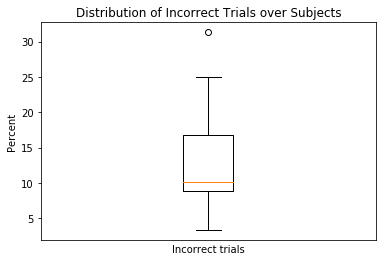

In [20]:
# Boxplot of incorrect trial distribution
# display(np.median(bad_list))
plt.boxplot(bad_list)
plt.ylabel('Percent')
plt.xlabel('Incorrect trials')
plt.title('Distribution of Incorrect Trials over Subjects')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off


# create and save fig object
bad_trials = plt.gcf()

#pickle.dump(bad_trials, open(behav_plots + "bad_trials.p", "wb"))

## 2 - Distribution of all valid alphas

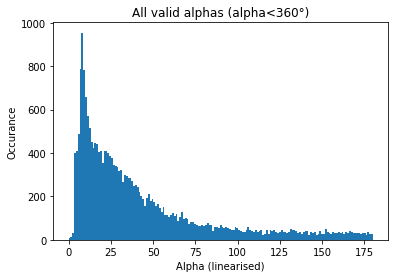

In [21]:
# get the distribution of valid alphas
#all_subs[all_subs["alpha"] <= 360]["alpha_lin"].plot.hist(bins=len(all_subs)//20)
all_subs[all_subs["alpha"] <= 360]["alpha_lin"].plot.hist(bins=bin_size)
plt.xlabel('Alpha (linearised)')
plt.ylabel('Occurance')
plt.title('All valid alphas (alpha<360°)')
# create fig object
alpha_all = plt.gcf()
# save fig object
#pickle.dump(alpha_all, open(behav_plots + "alpha_all.p", 'wb'))

In [22]:
np.ceil(np.sqrt(len(all_subs)))

165.0

## 3 - Distribution of all valid alphas per tapnr

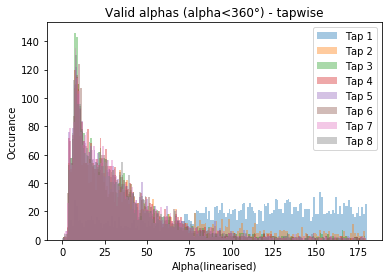

In [39]:
small_subs = all_subs[all_subs["alpha"] <= 360]

small_subs.groupby("tapnr")["alpha_lin"].plot.hist(bins=bin_size, alpha=0.4)
plt.legend(['Tap 1','Tap 2','Tap 3','Tap 4','Tap 5','Tap 6','Tap 7','Tap 8'])
plt.xlabel('Alpha(linearised)')
plt.ylabel("Occurance")
plt.title('Valid alphas (alpha<360°) - tapwise')

# create fig object
alpha_tapwise = plt.gcf()
# save fig object
#pickle.dump(alpha_tapwise, open(behav_plots + "alpha_tapwise.p", 'wb'))

## 4 - Taps in first 1.5 seconds vs. last 1.5 seconds

In [24]:
# save time of first and last tap per trial in dataframe
first_tap = all_subs.index - all_subs.index[all_subs.index%9]
all_subs["first_tap"] = all_subs["ttap"][first_tap].to_numpy()
last_tap = all_subs.index - all_subs.index[(all_subs.index%9)] +8
all_subs["last_tap"] = all_subs["ttap"][last_tap].to_numpy()


# TODO: Perform a Shapiro-Wilk normality test
# TODO: Test H0

6368

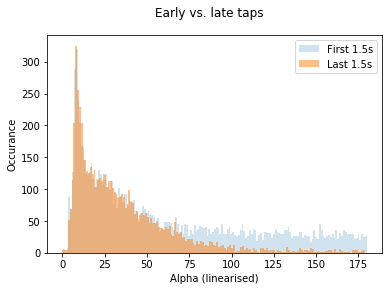

In [35]:
# only use alpha values of correct trials
all_subs = all_subs[all_subs["alpha"] <= 360]

# Plot those alpha values that occur within the range of first tap + 1.5s and last tap - 1.5s (of each trial)
all_subs[all_subs["ttap"] <= all_subs.first_tap+1.5 ]["alpha_lin"].plot.hist(bins=bin_size)
all_subs[all_subs["ttap"] >= all_subs.last_tap-1.5 ]["alpha_lin"].plot.hist(bins=bin_size)
plt.suptitle('Early vs. late taps')
plt.legend(['First 1.5s','Last 1.5s'])
plt.xlabel('Alpha (linearised)')
plt.ylabel('Occurance')

# create fig object
early_vs_late_taps = plt.gcf()
# save fig object
#pickle.dump(early_vs_late_taps, open(behav_plots + "early_vs_late.p", 'wb'))

len(all_subs[all_subs["ttap"] >= all_subs.last_tap-1.5 ]["alpha_lin"])

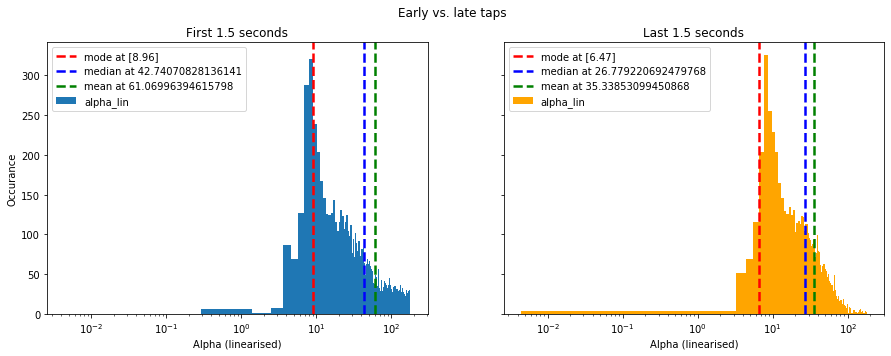

In [44]:
# only use alpha values of correct trials
all_subs = all_subs[all_subs["alpha"] <= 360]

# Plot those alpha values that occur within the range of first tap + 1.5s and last tap - 1.5s (of each trial)
first = all_subs[all_subs["ttap"] <= all_subs.first_tap+1.5 ]
first_mean = np.mean(first["alpha_lin"])
first_median = np.median(first["alpha_lin"])
first_mode,xyz = stats.mode(np.around(first["alpha_lin"], decimals=2))
#first_mode = max(first["alpha_lin"], key = first["alpha_lin"].count)


last = all_subs[all_subs["ttap"] >= all_subs.last_tap-1.5 ]
last_mean = np.mean(last["alpha_lin"])
last_median = np.median(last["alpha_lin"])
last_mode,xyz2 = stats.mode(np.around(last["alpha_lin"], decimals=2))

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5), sharey=True, sharex=True)
plt.suptitle('Early vs. late taps')
first["alpha_lin"].plot.hist(bins=bin_size, ax = axes[0], logx=True)
last["alpha_lin"].plot.hist(bins=bin_size, ax = axes[1], color='orange', logx=True)

axes[0].set_xlabel("Alpha (linearised)")
axes[0].set_ylabel("Occurance")
axes[0].set_title("First 1.5 seconds")
axes[1].set_xlabel("Alpha (linearised)")
axes[1].set_title("Last 1.5 seconds")

names = ["mode", "median", "mean"]
colors = ['red', 'blue', 'green']
first_measurement = [first_mode, first_median, first_mean]
last_measurement = [last_mode, last_median, last_mean]


#axes[0].axvline(x=first_median, linestyle='--', linewidth=2.5, label='median', c='green')
#axes[0].axvline(x=first_mean, linestyle='--', linewidth=2.5, label='mean', c='blue')
#axes[0].axvline(x=first_mode, linestyle='--', linewidth=2.5, label='mode', c='red')





for first_measurement, name, color in zip(first_measurement, names, colors):
    axes[0].axvline(x=first_measurement, linestyle='--', linewidth=2.5, 
                label='{0} at {1}'.format(name, first_measurement), c=color)
axes[0].legend();

for last_measurement, name, color in zip(last_measurement, names, colors):
    axes[1].axvline(x=last_measurement, linestyle='--', linewidth=2.5, 
                label='{0} at {1}'.format(name, last_measurement), c=color)
axes[1].legend();


# create fig object
#early_vs_late_taps = plt.gcf()
# save fig object
#pickle.dump(early_vs_late_taps, open(behav_plots + "early_vs_late.p", 'wb'))

#len(all_subs[all_subs["ttap"] >= all_subs.last_tap-1.5 ]["alpha_lin"])

### 4.2 early vs. late - pairwise

### 4.3 - Statistics

In [27]:
all_subs = all_subs[all_subs["alpha"] <= 360]

first_taps = all_subs[all_subs["ttap"] <= all_subs.first_tap+1.5 ]["alpha_lin"]
last_taps = all_subs[all_subs["ttap"] >= all_subs.last_tap-1.5 ]["alpha_lin"]

#ks, p = kstest(first_taps, "norm")

alpha_level = .05
shap_f, p_f = stats.shapiro(first_taps)
shap_l, p_l = stats.shapiro(last_taps)


if p_f < alpha_level:
    print("Alpha values of first taps are not normal distributed")
else:
    print("Alpha values of first taps are not normal distributed")
    
if p_l < alpha_level:
    print("Alpha values of last taps are not normal distributed")
else:
    print("Alpha values of last taps are not normal distributed")
    
# Test for difference between first and last taps
mws, p = stats.mannwhitneyu(first_taps,last_taps)
mws,p

if p < alpha_level:
    print("reject H0")
else:
    print("H0 not rejectable")
    


Alpha values of first taps are not normal distributed
Alpha values of last taps are not normal distributed
reject H0


/net/store/nbp/projects/hyperscanning/study_project/programming_tools/miniconda3/envs/hyperscanning/lib/python3.8/site-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [28]:
print(len(first_taps),len(last_taps))

8890 6368


### 4.2 - Boxplot early vs. late

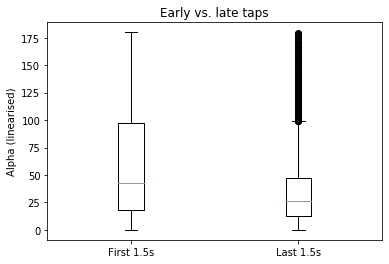

In [29]:
plt.boxplot([all_subs[all_subs["ttap"] <= all_subs.first_tap+1.5 ]["alpha_lin"],
             all_subs[all_subs["ttap"] >= all_subs.last_tap-1.5 ]["alpha_lin"]])

#display(np.median(all_subs[all_subs["ttap"] <= all_subs.first_tap+1.5 ]["alpha_lin"]))
#display(np.median(all_subs[all_subs["ttap"] >= all_subs.last_tap-1.5 ]["alpha_lin"]))
plt.title("Early vs. late taps")
plt.ylabel("Alpha (linearised)")
plt.xticks(ticks=np.arange(1,3),labels=["First 1.5s","Last 1.5s"])

# create fig object
boxplot_early_vs_late = plt.gcf()
# save fig object
#pickle.dump(boxplot_early_vs_late, open(behav_plots + "boxplot_early_vs_late.p", 'wb'))

## 5 - Alpha over Blocks

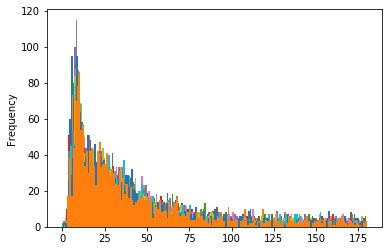

In [30]:
all_subs = all_subs[all_subs["alpha"] <= 360]

alpha_block = all_subs.groupby("block")
alpha_block["alpha_lin"].plot.hist(bins=bin_size)

# create fig object
alpha_blocks = plt.gcf()
# save fig object
#pickle.dump(alpha_blocks, open(behav_plots + "alpha_blocks.p", 'wb'))

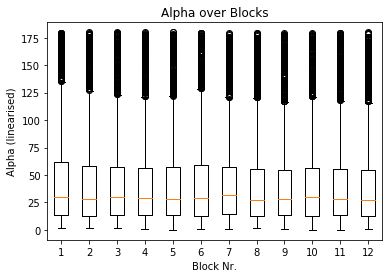

In [31]:
plt.boxplot([all_subs[all_subs["block"]==1]["alpha_lin"],
            all_subs[all_subs["block"]==2]["alpha_lin"],
            all_subs[all_subs["block"]==3]["alpha_lin"],
            all_subs[all_subs["block"]==4]["alpha_lin"],
            all_subs[all_subs["block"]==5]["alpha_lin"],
            all_subs[all_subs["block"]==6]["alpha_lin"],
            all_subs[all_subs["block"]==7]["alpha_lin"],
            all_subs[all_subs["block"]==8]["alpha_lin"],
            all_subs[all_subs["block"]==9]["alpha_lin"],
            all_subs[all_subs["block"]==10]["alpha_lin"],
            all_subs[all_subs["block"]==11]["alpha_lin"],
            all_subs[all_subs["block"]==12]["alpha_lin"]]
           )
plt.title("Alpha over Blocks")
plt.ylabel("Alpha (linearised)")
plt.xlabel("Block Nr.")
plt.xticks(ticks=np.arange(1,13),labels=range(1,13))


# create fig object
boxplot_blocks = plt.gcf()
# save fig object
#pickle.dump(boxplot_blocks, open(behav_plots + "boxplot_blocks.p", 'wb'))